# Correlations
In this file I will:
- Do a basic exploration of the top ten counties that permit the most solar.
- Do a time series analysis to see how much solar has been permitted over the last ten years.
- Outline the correlations between income, education, age, and population density with solar farm density within Virginian localities.
- Attempt to disprove the null-hypothesis that: There is no sigificant correlation between population density and solar farm density for a given locality.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from scipy.stats import mannwhitneyu, shapiro
import numpy as np

deq_df = pd.read_csv('../csv_collection/deq_data_cleaned.csv')
county_df = pd.read_csv('../csv_collection/cleaned_counties.csv')

display(deq_df.head(3))
display(county_df.head(3))

,permit_name,megawatts,total_acres,disturbance_zone_acres,mitigation_plan,city/county,brownfield_site,noi_received,application_received,pbr_authorization_letter,construction_commenced,commercial_operation_commenced
0,360 Solar Center Project,52.0,800,450,YES,Chesterfield County,No,7/19/22,4/29/24,7/15/24,NaN,NaN
1,Altavista Solar LLC (FKA Dragonfly),80.0,"1,200",0,YES,Campbell County,No,9/12/18,5/31/19,8/8/19,3/11/20,6/4/21
2,"Alton Post Office Solar, LLC",75.0,768,501,No,Halifax County,No,10/6/17,9/15/20,12/7/20,9/20/23,12/24/24


,city/county,biden_votes,biden_%,trump_votes,trump_%,other_party_votes,other_party_%,margin_votes,margin_%,total_votes,population,area,pop_density_sqmi,affiliation_2020,median_household_income,bachelors_or_over_%,age_over_50_%
0,Accomack County,7578,44.68,9172,54.07,212,1.25,-1594,-9.39,16962,33411.0,455.0,73.430769,red,57500.0,21.8,47.3
1,Albemarle County,42466,65.68,20804,32.18,1387,2.14,21662,33.50,64657,117313.0,723.0,162.258645,blue,102617.0,60.6,38.3
2,Alexandria City,66240,80.28,14544,17.63,1724,2.09,51696,62.65,82508,NaN,NaN,NaN,blue,113638.0,65.8,30.2


## Basic Explorations

I'll start with getting a feel for the DEQ dataset. Seeing:
- What counties approved the most projects.
- What counties developed the most solar power.
- The distribution of project sizes per top counties.

In [2]:
# MW per county:

total_mw_per_county = deq_df.groupby('city/county')['megawatts'].sum().reset_index()

total_mw_per_county = total_mw_per_county.sort_values(by='megawatts', ascending=False)

print('The top ten counties with the most projects, and the total amount of solar they have permitted:')
display(total_mw_per_county.head(10))

The top ten counties with the most projects, and the total amount of solar they have permitted:


,city/county,megawatts
23,Louisa County,450.2
16,Halifax County,444.0
4,Buckingham County,269.5
33,Pulaski County,250.0
20,Isle of Wight County,236.0
29,Pittsylvania County,230.0
8,Chesapeake City,220.0
13,Frederick County,205.0
5,Campbell County,200.4
35,Rockingham County,200.0


Now I will graph these counties and their distribution of solar projects and megawatts:

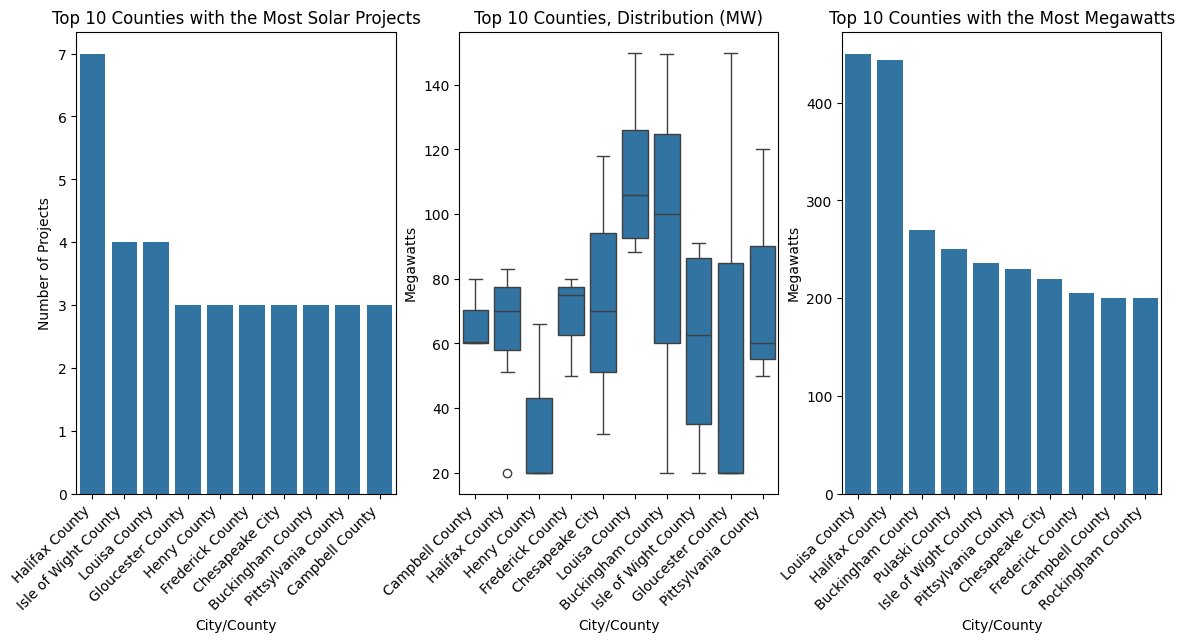

In [3]:
plt.figure(figsize=(14, 6))

# Graph 1:
ax1 = plt.subplot(1, 3, 1)
sns.countplot(
    x='city/county',
    data=deq_df,
    order=deq_df['city/county'].value_counts().index[:10]  # Sort by top 10
)
plt.xticks(rotation=45, ha='right')
plt.xlabel("City/County")
plt.ylabel("Number of Projects")
plt.title("Top 10 Counties with the Most Solar Projects")

# Graph 2:
top_counties = deq_df['city/county'].value_counts().index[:10]
top_counties_filtered_df = deq_df[deq_df['city/county'].isin(top_counties)]
ax2 = plt.subplot(1, 3, 2)
sns.boxplot(
    x='city/county',
    y='megawatts',
    data=top_counties_filtered_df
)
plt.xlabel("City/County")
plt.ylabel("Megawatts")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Counties, Distribution (MW)")

# Graph 3:
total_mw_per_county = deq_df.groupby('city/county')['megawatts'].sum().reset_index()
total_mw_per_county = total_mw_per_county.sort_values(by='megawatts', ascending=False)
ax3 = plt.subplot(1, 3, 3)
sns.barplot(
    x='city/county',
    y='megawatts',
    data=total_mw_per_county.head(10)
)
plt.xlabel("City/County")
plt.ylabel("Megawatts")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Counties with the Most Megawatts")

plt.show();

### Top Locality Summary:
The top ten counties follow some similar trends. Almost all of them have three or four projects, and almost all of them house 200 - 300 MW. It seems likely that these counties have adopted similar regulations on the size and density of solar projects. There are a couple outliers, Halifax and Louisa to be specific. Halifax has on average much smaller projects than most counties, but has a very high count. Louisa county has a normal number of projects, but the highest average size. 

## **Time Series Analysis**
Lets look at how many solar farms and megawatts were added each year.

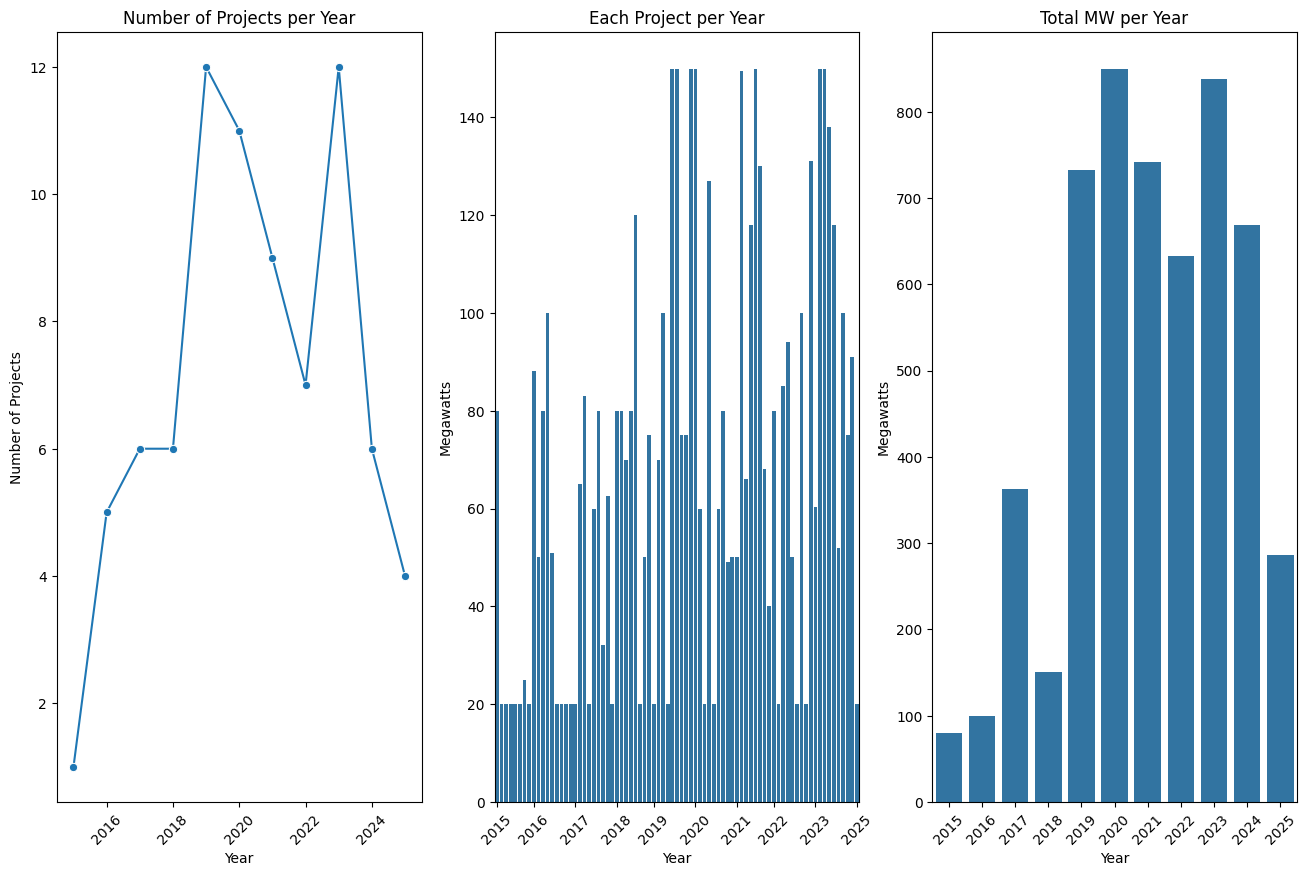

In [4]:
time_series_df = deq_df

# Graph 1: Projects per year
megawatts_per_year = time_series_df.groupby('pbr_authorization_letter')['megawatts'].sum().reset_index()
approved_per_year = []

# Grabbing the last two digits, to plot by year:
for farm in time_series_df['pbr_authorization_letter']:
    approval_year = 2000 + int(farm[-2:])
    approved_per_year.append(approval_year)
year_counts = pd.Series(approved_per_year).value_counts().sort_index()

# Graph 2:
# Extract the year from 'pbr_authorization_letter'
deq_df["year"] = deq_df["pbr_authorization_letter"].apply(lambda x: int(x.split("/")[-1]) + 2000)

# Sort the DataFrame by year (ascending)
deq_df_sorted = deq_df.sort_values(by="year")

# Graph 3: Megawatts per year
year_series = deq_df.groupby('year')['megawatts'].sum().reset_index()

#Graphing:
plt.figure(figsize=(16, 10))

ax1 = plt.subplot(1, 3, 1)
sns.lineplot(x=year_counts.index, y=year_counts.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Number of Projects")
plt.xticks(rotation=45)
plt.title("Number of Projects per Year")

ax2 = plt.subplot(1, 3, 2)
sns.barplot(
    x='permit_name',
    y='megawatts',
    data=deq_df_sorted
)
plt.xlabel("Year")
plt.ylabel("Megawatts")
plt.xticks(rotation=45)
plt.title("Each Project per Year")

# Graph 3:
tick_positions = np.linspace(0, len(deq_df_sorted) - 1, 10, dtype=int)
tick_labels = list(map(str, np.linspace(2015, 2025, 10, dtype=int)))
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
ax3 = plt.subplot(1, 3, 3)
sns.barplot(
    x='year',
    y='megawatts',
    data=year_series
)
plt.ylabel("Megawatts")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.title("Total MW per Year")

plt.show();


### Time Series Summary: 
The number of projects spread looks mostly aligned with the number of megawatts, meaning that as the number of projects increased so did the number of megawatts relatively equally. It took a few years for the amount of solar being added to peak in 2020, the same year as the Virginia Clean Economy Act, which makes sense. There seems to have been an influx of projects during that year, and production steadily leveled off until 2022, when it again spiked in 2023. One thing that is obvious from the graphs, is production was weaker pre-2020, it then spiked in 2020-2023, and it has begun to lower off again. Solar development has been unstable and volatile for the duration of the years analyzed.


# **Correlations**:
Here I will analyze the distributions, spread, and trends of income, education, age, and population density in counties with solar farms. Localities with multiple solar farms are included as-is to reflect their greater weight in the dataset. As a reference, I will also graph these statistics for all counties regardless of solar farm presence. To determine if differences between the two groups are statistically significant or due to random chance, I will use either t-tests (for normally distributed data) or Mann-Whitney U tests (for non-normal data).

## Income and Solar Density Correlation:

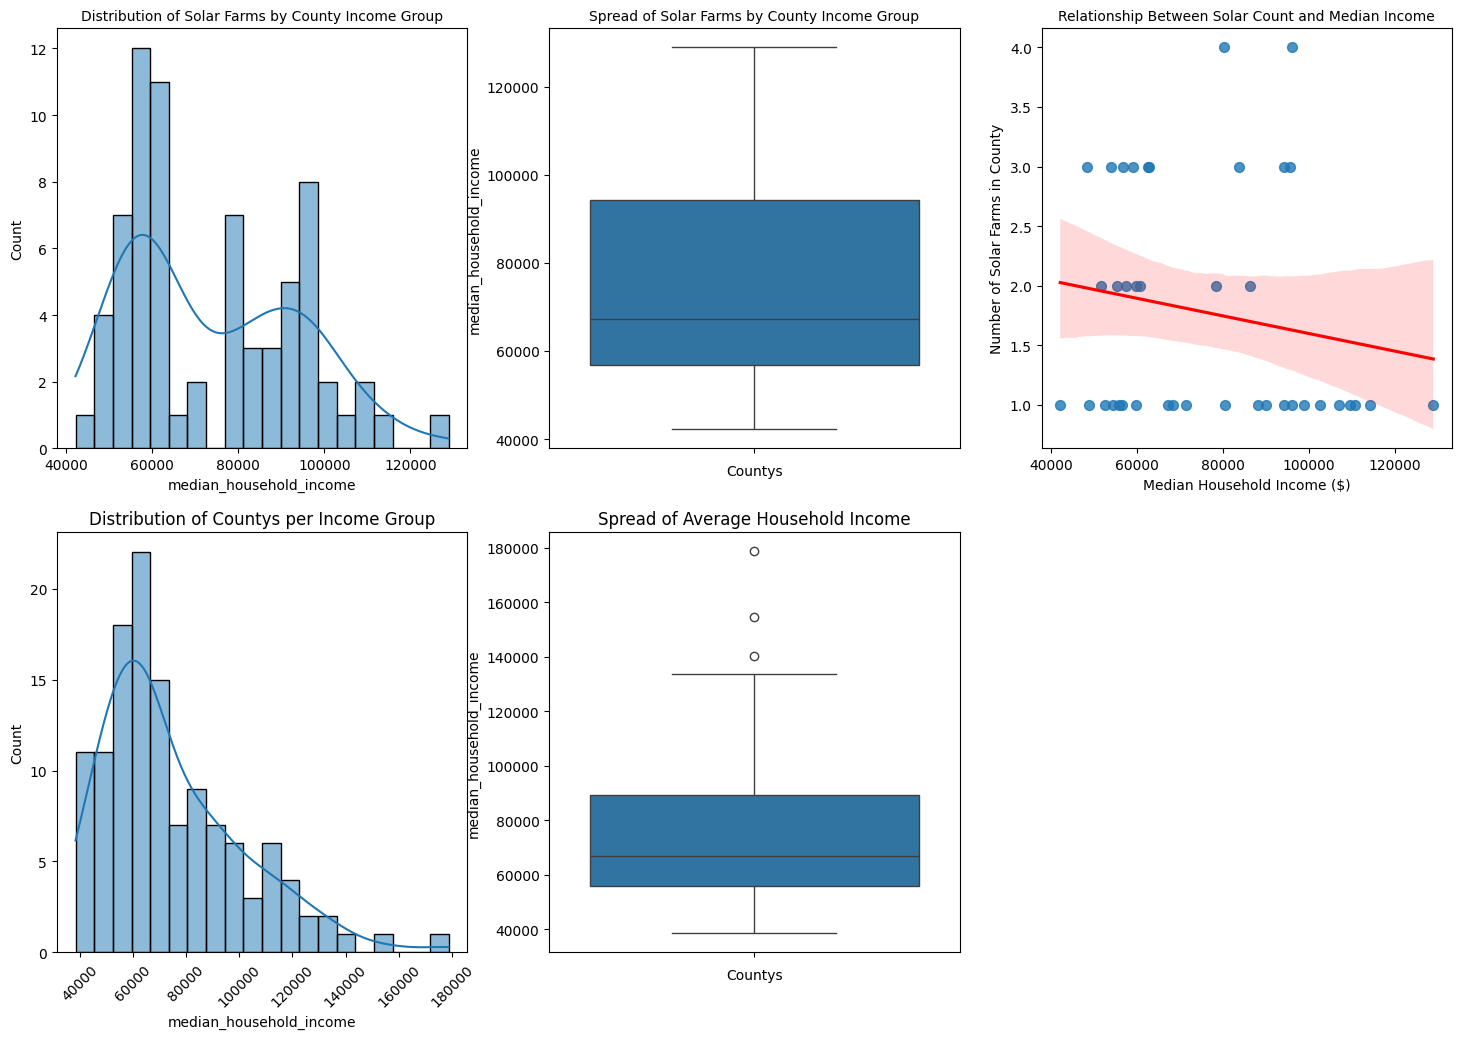

In [15]:
# Bring in income statistics per county, to the project DataFrame:
income_groups_df = pd.merge(
    deq_df,
    county_df[['city/county', 'median_household_income']],
    how='left',
    on='city/county'
)

# For graph 3:
county_farm_counts = income_groups_df.groupby('city/county').size().reset_index(name='num_farms')

# Get unique median income per county
county_income = income_groups_df[['city/county', 'median_household_income']].drop_duplicates()

# Merge farm counts with income data
county_data = county_farm_counts.merge(county_income, on='city/county')

# Graphing:
plt.figure(figsize=(18, 12))

# Graph 1:
ax1 = plt.subplot(2, 3, 1)
sns.histplot(
    x='median_household_income',
    data=income_groups_df,
    bins=20,
    kde=True
)
plt.title("Distribution of Solar Farms by County Income Group", fontsize=10)


# Graph 2:
ax2 = plt.subplot(2, 3, 2)
sns.boxplot(
    y=income_groups_df['median_household_income']
)
plt.xlabel('Countys')
plt.title("Spread of Solar Farms by County Income Group", fontsize=10)

# Graph 3:
ax3 = plt.subplot(2, 3, 3)
sns.regplot(
    x='median_household_income',
    y='num_farms',
    data=county_data,
    scatter_kws={'s': 50},
    line_kws={'color': 'red'},
)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Number of Solar Farms in County")
plt.title("Relationship Between Solar Count and Median Income", fontsize=10)



# Plotting baseline comparisons:


# Graph 4:
ax4 = plt.subplot(2, 3, 4)
sns.histplot(
    x='median_household_income',
    data=county_df,
    bins=20,
    kde=True
)
plt.xticks(rotation=45)
plt.title("Distribution of Countys per Income Group")



# Graph 5:
ax5 = plt.subplot(2, 3, 5)
sns.boxplot(
    y=county_df['median_household_income']
)
plt.xlabel('Countys')
plt.title("Spread of Average Household Income")

# Graph 3

plt.show();

In [6]:
# Now that I see the data is not normally distributed, I'll run a Mann-Whitney test. I'll also compare averages:

# Calculating p-values:
solar_income = income_groups_df['median_household_income'].dropna()
all_income = county_df['median_household_income'].dropna()

u_stat, p_value = mannwhitneyu(solar_income, all_income, alternative="two-sided")

print("Mann-Whitney U Statistic:", u_stat)
print("P-value:", p_value)

# Calculating averages:
solar_income_avg = income_groups_df['median_household_income'].mean()
all_income_avg = county_df['median_household_income'].mean()

print(f"Average median household income of counties with solar farms is: {solar_income_avg:.2f}")
print(f"Average median household income of a VA county is: {all_income_avg:.2f}")


Mann-Whitney U Statistic: 4572.5
P-value: 0.7966407201563974
Average median household income of counties with solar farms is: 74032.92
Average median household income of a VA county is: 74775.30


### Income Summary:
There is a high p-value (much greater than the 0.05 threshold), which indicates differences in the data are most likely due to random chance. The averages are also extrememly similar. Becaues the distribution and averages are so similar, this implies that there is no statistical significance of the effect of median household income on solar farm density in Virginia. 

## Education Correlations:

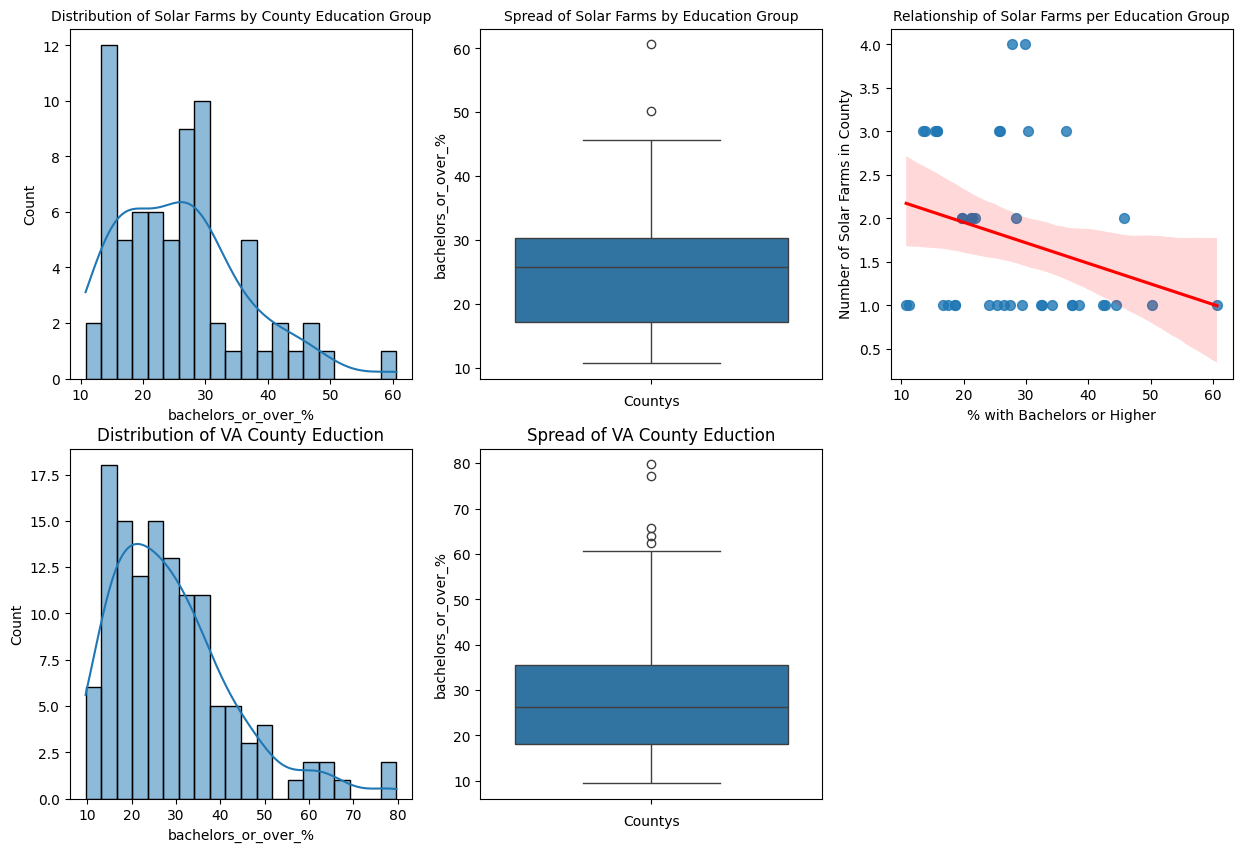

In [17]:
# Bring in education statistics per county, to the project DataFrame:
education_groups_df = pd.merge(
    deq_df,
    county_df[['city/county', 'bachelors_or_over_%']],
    on='city/county',
    how='left'
)

# Graph 3:
county_farm_counts = education_groups_df.groupby('city/county').size().reset_index(name='num_farms')
county_education = education_groups_df[['city/county', 'bachelors_or_over_%']].drop_duplicates()
county_data = county_farm_counts.merge(county_education, on='city/county')

# Graphing:
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 3, 1)
sns.histplot(
    x='bachelors_or_over_%',
    data=education_groups_df,
    bins=20,
    kde=True
)
plt.title("Distribution of Solar Farms by County Education Group", fontsize=10)


ax2 = plt.subplot(2, 3, 2)
sns.boxplot(
    y=education_groups_df['bachelors_or_over_%']
)
plt.xlabel("Countys")
plt.title("Spread of Solar Farms by Education Group", fontsize=10)

ax3 = plt.subplot(2, 3, 3)
sns.regplot(
    x='bachelors_or_over_%',
    y='num_farms',
    data=county_data,
    scatter_kws={'s': 50},
    line_kws={'color': 'red'},
)
plt.xlabel("% with Bachelors or Higher")
plt.ylabel("Number of Solar Farms in County")
plt.title("Relationship of Solar Farms per Education Group", fontsize=10)



# Plotting baseline comparisons:


ax4 = plt.subplot(2, 3, 4)
sns.histplot(
    x='bachelors_or_over_%',
    data=county_df,
    bins=20,
    kde=True
)
plt.title("Distribution of VA County Eduction")


ax5 = plt.subplot(2, 3, 5)
sns.boxplot(
    y=county_df['bachelors_or_over_%']
)
plt.xlabel("Countys")
plt.title("Spread of VA County Eduction")


plt.show();

In [8]:
# Now that I see the data is not normally distributed, I'll run a Mann-Whitney test. I'll also compare averages:

# p-values:
solar_edu = education_groups_df['bachelors_or_over_%'].dropna()
all_edu = county_df['bachelors_or_over_%'].dropna()

u_stat, p_value = mannwhitneyu(solar_edu, all_edu, alternative="two-sided")

print("Mann-Whitney U Statistic:", u_stat)
print("P-value:", p_value)

# Averages:
solar_edu_avg = education_groups_df['bachelors_or_over_%'].mean()
all_ed_avg = county_df['bachelors_or_over_%'].mean()

print(f"The average percent of a county's adult population with bachelors degrees or over (that have solar farms), is: {solar_edu_avg:.2f}")
print(f"The average percent of a county's adult population with bachelors degrees or over, is: {all_ed_avg:.2f}")


Mann-Whitney U Statistic: 4031.5
P-value: 0.25098648952341573
The average percent of a county's adult population with bachelors degrees or over (that have solar farms), is: 25.95
The average percent of a county's adult population with bachelors degrees or over, is: 29.07


### Education Summary:
There is a high p-value (much greater than the 0.05 threshold), which indicates differences in the data are most likely due to random chance. The averages are also extrememly similar. Becaues the distribution and averages are so similar, this implies that there is no statistical significance of the effect of education on solar farm density in Virginia.

## Age Correlations:

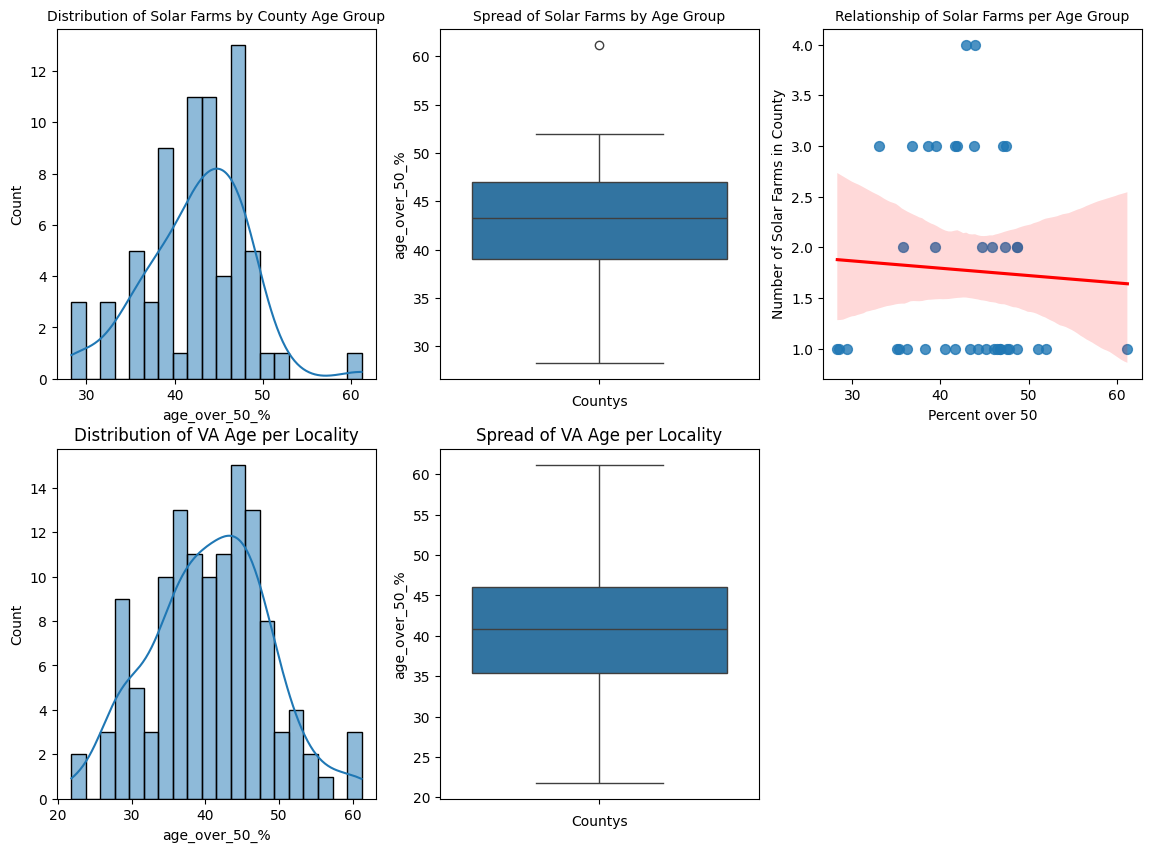

In [19]:
# Bring in age statistics per county, to the project DataFrame:
age_groups_df = pd.merge(
    deq_df,
    county_df[['city/county', 'age_over_50_%']],
    on='city/county',
    how='left'
)

# Graph 3:
county_farm_counts = age_groups_df.groupby('city/county').size().reset_index(name='num_farms')
county_age = age_groups_df[['city/county', 'age_over_50_%']].drop_duplicates()
county_data = county_farm_counts.merge(county_age, on='city/county')

# Graphing:
plt.figure(figsize=(14, 10))

ax1 = plt.subplot(2, 3, 1)
sns.histplot(
    x='age_over_50_%',
    data=age_groups_df,
    bins=20,
    kde=True
)
plt.title("Distribution of Solar Farms by County Age Group", fontsize=10)


ax2 = plt.subplot(2, 3, 2)
sns.boxplot(
    y=age_groups_df['age_over_50_%']
)
plt.xlabel("Countys")
plt.title("Spread of Solar Farms by Age Group", fontsize=10)

ax3 = plt.subplot(2, 3, 3)
sns.regplot(
    x='age_over_50_%',
    y='num_farms',
    data=county_data,
    scatter_kws={'s': 50},
    line_kws={'color': 'red'},
)
plt.xlabel("Percent over 50")
plt.ylabel("Number of Solar Farms in County")
plt.title("Relationship of Solar Farms per Age Group", fontsize=10)



# Plotting baseline comparisons:


ax4 = plt.subplot(2, 3, 4)
sns.histplot(
    x='age_over_50_%',
    data=county_df,
    bins=20,
    kde=True
)
plt.title("Distribution of VA Age per Locality")


ax5 = plt.subplot(2, 3, 5)
sns.boxplot(
    y=county_df['age_over_50_%']
)
plt.xlabel("Countys")
plt.title("Spread of VA Age per Locality")


plt.show();

In [10]:
# I can't visually tell if this data is normally distributed or not, so I'll run a test:
solar_age = age_groups_df['age_over_50_%'].dropna()
all_age = county_df['age_over_50_%'].dropna()

print("Shapiro Test (Solar Counties):", shapiro(solar_age))
print("Shapiro Test (All Counties):", shapiro(all_age))

Shapiro Test (Solar Counties): ShapiroResult(statistic=0.963196754109159, pvalue=0.03555881085929516)
Shapiro Test (All Counties): ShapiroResult(statistic=0.989887039366443, pvalue=0.48738625317549666)


In [11]:
# Now that I see that some of the data is not normally distributed, I'll run a Mann-Whitney test. I'll also compare averages:

# p-values:
u_stat, p_value = mannwhitneyu(solar_age, all_age, alternative="two-sided")

print("Mann-Whitney U Statistic:", u_stat)
print("P-value:", p_value)

# averages:
solar_age_avg = age_groups_df['age_over_50_%'].mean()
all_age_avg = county_df['age_over_50_%'].mean()

print(f"The percent of a county's (that have solar farms) population who's age is over 50 is: {solar_age_avg:.2f}")
print(f"The percent of a county's population who's age is over 50 is: {all_age_avg:.2f}")


Mann-Whitney U Statistic: 5175.5
P-value: 0.0676279607784501
The percent of a county's (that have solar farms) population who's age is over 50 is: 42.51
The percent of a county's population who's age is over 50 is: 40.65


### Age Summary:
There is a high p-value (greater than the 0.05 threshold), which indicates differences in the data are most likely due to random chance. The averages are also extrememly similar. Becaues the distribution and averages are so similar, this implies that there is no statistical significance of the effect of age on solar farm density in Virginia.


## Population Density Correlations:

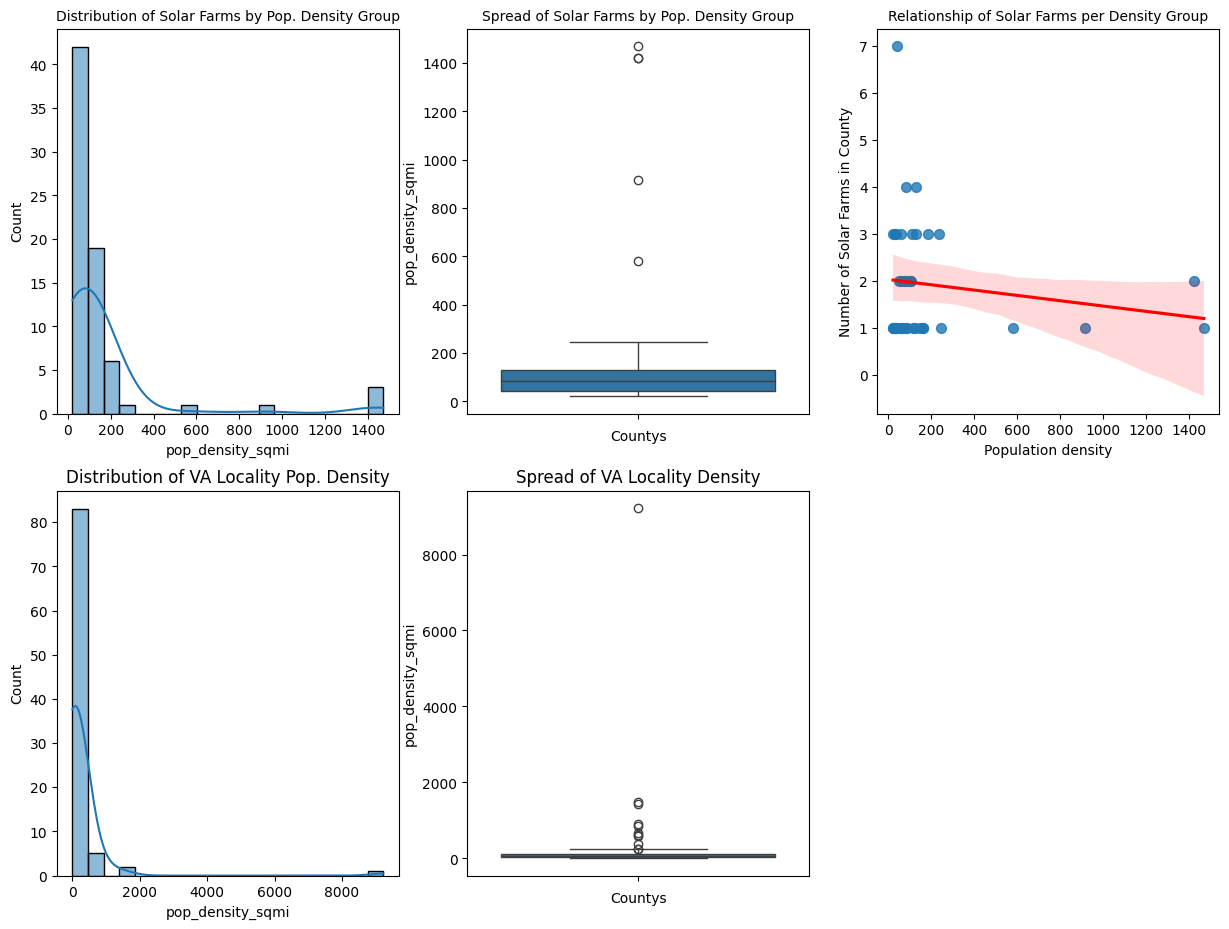

In [21]:
# Bring in population statistics per county, to the project DataFrame:
population_groups_df = pd.merge(
    deq_df,
    county_df[['city/county', 'pop_density_sqmi']],
    on='city/county',
    how='left'
)

# Graph 3:
county_farm_counts = population_groups_df.groupby('city/county').size().reset_index(name='num_farms')
county_population = population_groups_df[['city/county', 'pop_density_sqmi']].drop_duplicates()
county_data = county_farm_counts.merge(county_population, on='city/county')

# Graphing:
plt.figure(figsize=(15, 11))

ax1 = plt.subplot(2, 3, 1)
sns.histplot(
    x='pop_density_sqmi',
    data=population_groups_df,
    bins=20,
    kde=True
)
plt.title("Distribution of Solar Farms by Pop. Density Group", fontsize=10)


ax2 = plt.subplot(2, 3, 2)
sns.boxplot(
    y=population_groups_df['pop_density_sqmi']
)
plt.xlabel("Countys")
plt.title("Spread of Solar Farms by Pop. Density Group", fontsize=10)

ax3 = plt.subplot(2, 3, 3)
sns.regplot(
    x='pop_density_sqmi',
    y='num_farms',
    data=county_data,
    scatter_kws={'s': 50},
    line_kws={'color': 'red'},
)
plt.xlabel("Population density")
plt.ylabel("Number of Solar Farms in County")
plt.title("Relationship of Solar Farms per Density Group", fontsize=10)



# Plotting baseline comparisons:


ax4 = plt.subplot(2, 3, 4)
sns.histplot(
    x='pop_density_sqmi',
    data=county_df,
    bins=20,
    kde=True
)
plt.title("Distribution of VA Locality Pop. Density")


ax5 = plt.subplot(2, 3, 5)
sns.boxplot(
    y=county_df['pop_density_sqmi']
)
plt.xlabel("Countys")
plt.title("Spread of VA Locality Density")


plt.show();

In [13]:
# Now that I see the data is not normally distributed, I'll run a Mann-Whitney test. I'll also compare averages:

# p-values:
solar_density = population_groups_df['pop_density_sqmi'].dropna()
all_density = county_df['pop_density_sqmi'].dropna()

u_stat, p_value = mannwhitneyu(solar_edu, all_edu, alternative="two-sided")

print("Mann-Whitney U Statistic:", u_stat)
print("P-value:", p_value)

# Averages:
solar_density_avg = population_groups_df['pop_density_sqmi'].mean()
all_density_avg = county_df['pop_density_sqmi'].mean()

print(f"Average population density per sq mi of countys with solar farms is: {solar_density_avg:.2f}")
print(f"Average population density per sq mi of a VA county is: {all_density_avg:.2f}")


Mann-Whitney U Statistic: 4031.5
P-value: 0.25098648952341573
Average population density per sq mi of countys with solar farms is: 162.03
Average population density per sq mi of a VA county is: 246.54


### Population density summary:
There is a high p-value (greater than the 0.05 threshold), which indicates differences in the data are **most likely** due to random chance. However, there are some outliers in the solar density data set, which can heavily skew the probability test. Also, the visual graph tells a compelling story, as does the high difference in averages. Without further testing, I cannot statistically confirm that population density is a key factor in solar farm density. However, the big picture (means, visuals), is pointing to the fact that population density most likely plays a key factor in solar farm density per county. 

I cannot statistically disprove the null hypothesis. However, among the other sociographic and demographic findings, it does play the largest part in indicating where a solar farm will be permitted.